# 基于机器学习可解释性分析的信贷预测案例研究


In [ ]:
# 这个库用到了处理不平衡数据集的库imbalanced-learn，所以需要安装这个库，建议去anaconda prompt中安装
# !pip install imbalanced-learn -i https://pypi.tuna.tsinghua.edu.cn/simple
# !pip install shap -i https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
# 忽视警告，这个库是内置的，不需要安装
import warnings
warnings.filterwarnings('ignore')

# 认识数据

In [3]:
import pandas as pd

# 使用pandas的read_csv函数读取CSV文件
data = pd.read_csv('data.csv')

# # 随机打乱数据集，这一步的操作是可选的，类似于把练习题不断更改顺序，防止电脑学习到固定的顺序，这一步是可选的
# random_seed = 77
# data = data.sample(frac=1, random_state=random_seed)

# 显示前几行数据，以确认数据已正确加载

data.head()

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


显然id列是噪声列，可以删除

In [4]:
data = data.drop(columns=['Id'])
data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


可以明显发现id其实是一个冗余的信息，其实可以删除，但是由于很多模型对于id本身并不敏感，在最后的解释性上可以看到id这一列几乎没有影响


In [5]:
data.shape # 查看数据集的行数和列数

(7500, 17)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### 数据集信息

- **数据集类型**: `pandas.core.frame.DataFrame`
- **总行数**: 7500 条记录
- **索引范围**: 从 2125 到 6871
- **总列数**: 18 列

---

### 列信息

| 列名                             | 非空值数量 | 数据类型   | 说明                                                                 |
|----------------------------------|------------|------------|----------------------------------------------------------------------|
| **Id**                           | 7500       | `int64`    | 每条记录的唯一标识符。                                               |
| **Home Ownership**               | 7500       | `object`   | 房屋所有权状态（可能是分类变量，如 "Own", "Rent" 等）。              |
| **Annual Income**                | 5943       | `float64`  | 年收入（有缺失值，7500 条记录中只有 5943 条有值）。                  |
| **Years in current job**         | 7129       | `object`   | 在当前工作的年限（可能是分类变量，如 "<1 year", "5+ years" 等）。    |
| **Tax Liens**                    | 7500       | `float64`  | 税务留置权数量（无缺失值）。                                         |
| **Number of Open Accounts**      | 7500       | `float64`  | 当前开放的账户数量（无缺失值）。                                     |
| **Years of Credit History**      | 7500       | `float64`  | 信用历史年限（无缺失值）。                                           |
| **Maximum Open Credit**          | 7500       | `float64`  | 最大开放信用额度（无缺失值）。                                       |
| **Number of Credit Problems**    | 7500       | `float64`  | 信用问题数量（无缺失值）。                                           |
| **Months since last delinquent** | 3419       | `float64`  | 上次违约以来的月数（有较多缺失值，7500 条记录中只有 3419 条有值）。 |
| **Bankruptcies**                 | 7486       | `float64`  | 破产次数（有少量缺失值，7500 条记录中只有 7486 条有值）。            |
| **Purpose**                      | 7500       | `object`   | 贷款目的（可能是分类变量，如 "Debt Consolidation", "Home Improvement" 等）。 |
| **Term**                         | 7500       | `object`   | 贷款期限（可能是分类变量，如 "Short Term", "Long Term" 等）。        |
| **Current Loan Amount**          | 7500       | `float64`  | 当前贷款金额（无缺失值）。                                           |
| **Current Credit Balance**       | 7500       | `float64`  | 当前信用余额（无缺失值）。                                           |
| **Monthly Debt**                 | 7500       | `float64`  | 月债务（无缺失值）。                                                 |
| **Credit Score**                 | 5943       | `float64`  | 信用评分（有缺失值，7500 条记录中只有 5943 条有值）。                |
| **Credit Default**               | 7500       | `int64`    | 是否违约（目标变量，可能是 0 或 1，表示是否违约）。                  |

---

### 数据类型分布

- **数值型 (`float64` 和 `int64`)**:
  - 共 14 列，包括 `Id`, `Annual Income`, `Tax Liens`, `Number of Open Accounts`, `Years of Credit History`, `Maximum Open Credit`, `Number of Credit Problems`, `Months since last delinquent`, `Bankruptcies`, `Current Loan Amount`, `Current Credit Balance`, `Monthly Debt`, `Credit Score`, `Credit Default`。
- **对象型 (`object`)**:
  - 共 4 列，包括 `Home Ownership`, `Years in current job`, `Purpose`, `Term`。这些列通常是分类变量或文本数据。

---

### 缺失值情况

- **无缺失值的列**:
  - `Id`, `Home Ownership`, `Tax Liens`, `Number of Open Accounts`, `Years of Credit History`, `Maximum Open Credit`, `Number of Credit Problems`, `Purpose`, `Term`, `Current Loan Amount`, `Current Credit Balance`, `Monthly Debt`, `Credit Default`。
- **有缺失值的列**:
  - `Annual Income`: 缺失 1557 条记录。
  - `Years in current job`: 缺失 371 条记录。
  - `Months since last delinquent`: 缺失 4081 条记录。
  - `Bankruptcies`: 缺失 14 条记录。
  - `Credit Score`: 缺失 1557 条记录。

---

### 内存使用

- 内存占用: 1.1+ MB

In [7]:
data.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


# 认识问题

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder # 用于特征标准化、独热编码和数值编码
from sklearn.model_selection import train_test_split # 用于将数据集划分为训练集和测试集


# 分离特征数据和标签数据
X = data.drop(['Credit Default'], axis=1)  # 特征数据
y = data['Credit Default']  # 标签数据

y

0       0
1       1
2       0
3       0
4       0
       ..
7495    0
7496    1
7497    0
7498    0
7499    0
Name: Credit Default, Length: 7500, dtype: int64

In [9]:
# 查看标签数据的分布
y.value_counts()

Credit Default
0    5387
1    2113
Name: count, dtype: int64

# 数据预处理

In [10]:
# 填补缺失值，使用众数
for column in X.columns:
    if X[column].dtype in ['float64', 'int64']:
        mode = X[column].mode()[0]
        X[column].fillna(mode, inplace=True)


# 分离连续特征和离散特征
continuous_features = X.select_dtypes(include=['float64', 'int64']).columns
discrete_features = X.select_dtypes(include=['object']).columns


# 连续特征标准化
scaler = StandardScaler()
X_continuous = scaler.fit_transform(X[continuous_features])


# 离散特征编码
# 对于有序离散特征使用数值编码
label_encoder = LabelEncoder()
# 假设 'Years in current job' 是有序离散特征，将其编码为数值
X['Years in current job'] = label_encoder.fit_transform(X['Years in current job'])


# 对于无序离散特征使用独热编码
onehot_encoder = OneHotEncoder()
X_discrete = onehot_encoder.fit_transform(X[discrete_features.drop('Years in current job')])


# 组合处理后的连续特征和离散特征
X = pd.concat([pd.DataFrame(X_continuous, columns=continuous_features),
              pd.DataFrame(X_discrete.toarray(), columns=onehot_encoder.get_feature_names_out(discrete_features.drop('Years in current job')))], axis=1)


# 使用 train_test_split 函数按照 8:2 的比例划分数据集
# test_size=0.2 表示 20%的数据用作测试集，即验证集。
# random_state 是一个随机数种子，确保每次划分的结果相同，便于复现结果。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# 打印处理后的数据集信息
X_train.info()
# X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, 4664 to 7270
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 6000 non-null   float64
 1   Tax Liens                     6000 non-null   float64
 2   Number of Open Accounts       6000 non-null   float64
 3   Years of Credit History       6000 non-null   float64
 4   Maximum Open Credit           6000 non-null   float64
 5   Number of Credit Problems     6000 non-null   float64
 6   Months since last delinquent  6000 non-null   float64
 7   Bankruptcies                  6000 non-null   float64
 8   Current Loan Amount           6000 non-null   float64
 9   Current Credit Balance        6000 non-null   float64
 10  Monthly Debt                  6000 non-null   float64
 11  Credit Score                  6000 non-null   float64
 12  Home Ownership_Have Mortgage  6000 non-null   float64
 13  Home 

In [12]:
# 对训练集进行过采样

from imblearn.over_sampling import SMOTE

# 使用 SMOTE 进行过采样,并赋值给自己
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [13]:
X_train.info()
# X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8656 entries, 0 to 8655
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 8656 non-null   float64
 1   Tax Liens                     8656 non-null   float64
 2   Number of Open Accounts       8656 non-null   float64
 3   Years of Credit History       8656 non-null   float64
 4   Maximum Open Credit           8656 non-null   float64
 5   Number of Credit Problems     8656 non-null   float64
 6   Months since last delinquent  8656 non-null   float64
 7   Bankruptcies                  8656 non-null   float64
 8   Current Loan Amount           8656 non-null   float64
 9   Current Credit Balance        8656 non-null   float64
 10  Monthly Debt                  8656 non-null   float64
 11  Credit Score                  8656 non-null   float64
 12  Home Ownership_Have Mortgage  8656 non-null   float64
 13  Hom

# 开始建模和训练

## 错误案例：把线性回归用来做分类问题

roc曲线是用阈值来画的，所以可以看到结果，之前没有打印混淆矩阵，差点就被迷惑了

In [14]:
# 导入所需的库
import pandas as pd  # 用于数据处理和分析
import numpy as np  # 用于数值计算
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder  # 用于数据预处理
from sklearn.model_selection import train_test_split, GridSearchCV  # 用于数据集划分和超参数调优
from sklearn.linear_model import LinearRegression  # 线性回归模型
from sklearn.linear_model import LogisticRegression  # 逻辑回归模型
from sklearn.svm import SVC  # 支持向量机分类模型
from sklearn.naive_bayes import GaussianNB  # 高斯朴素贝叶斯模型
from sklearn.ensemble import RandomForestClassifier  # 随机森林分类模型
import xgboost as xgb  # XGBoost模型
import lightgbm as lgb  # LightGBM模型
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report  # 用于模型评估
import warnings
# 忽略所有警告
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt # 绘图

print("Linear Regression:")
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
# conf_matrix = confusion_matrix(y_test, y_pred_lr)
# y_pred_lr
print("AUC: ", roc_auc_score(y_test, y_pred_lr))

Linear Regression:
AUC:  0.7706966954235266


## 逻辑回归

In [15]:
# 逻辑回归用于分类问题，不调参
print("Logistic Regression:")
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("AUC: ", roc_auc_score(y_test, y_pred_lr))

Logistic Regression:
Confusion Matrix:
 [[741 318]
 [151 290]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.70      0.76      1059
           1       0.48      0.66      0.55       441

    accuracy                           0.69      1500
   macro avg       0.65      0.68      0.66      1500
weighted avg       0.73      0.69      0.70      1500

AUC:  0.6786565428815531


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# 假设你已经有了数据集 X 和标签 y
# X 是特征矩阵，y 是标签向量

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义逻辑回归模型
lr = LogisticRegression()

# 定义参数网格
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # 正则化强度的倒数
    'penalty': ['l1', 'l2'],       # 正则化类型
    'solver': ['liblinear']        # 优化算法（liblinear 支持 l1 和 l2）
}

# 初始化网格搜索
grid_search = GridSearchCV(
    estimator=lr,  # 模型
    param_grid=param_grid,  # 参数网格
    cv=5,  # 五折交叉验证
    scoring='roc_auc',  # 使用 AUC 作为评估指标
    n_jobs=-1  # 使用所有可用的CPU核心
)

# 在训练集上执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数组合:", grid_search.best_params_)

# 使用最佳参数训练模型
best_lr = grid_search.best_estimator_

# 在测试集上进行预测
y_pred_lr = best_lr.predict(X_test)

# 输出混淆矩阵
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# 输出分类报告
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# 输出 AUC
y_pred_proba = best_lr.predict_proba(X_test)[:, 1]  # 获取正类的概率
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_proba))

最佳参数组合: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Confusion Matrix:
 [[1038   21]
 [ 335  106]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.98      0.85      1059
           1       0.83      0.24      0.37       441

    accuracy                           0.76      1500
   macro avg       0.80      0.61      0.61      1500
weighted avg       0.78      0.76      0.71      1500

测试集 AUC:  0.7704975600564432


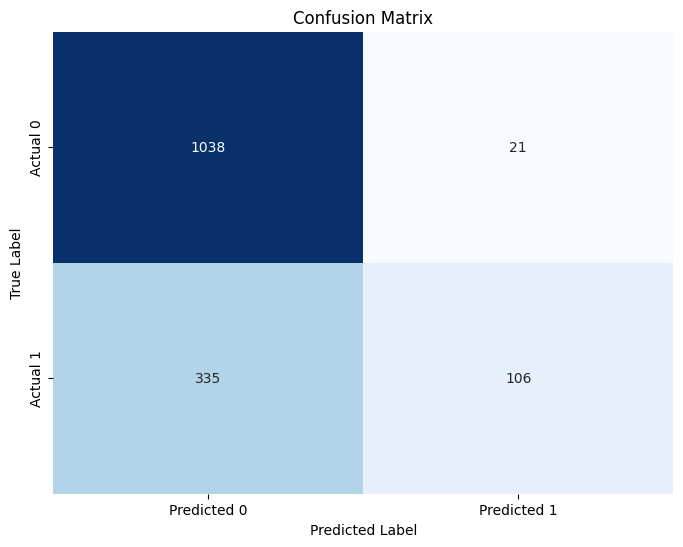

In [17]:
# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred_lr)

# 使用 seaborn 绘制彩色混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## SVM

这个算法解释性很差，而且速度很慢，所以不推荐使用

In [18]:
# 定义 SVM 模型（使用默认参数）
svm = SVC(probability=True, random_state=42)  # 启用概率估计

# 训练模型
svm.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_proba = svm.predict_proba(X_test)[:, 1]  # 获取正类的概率

# 输出测试集 AUC
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_proba))

测试集 AUC:  0.7331179245384021


In [19]:
# 定义 SVM 模型
svm = SVC(probability=True, random_state=42)  # 启用概率估计

# 定义参数网格
param_grid = {
    'C': [0.1, 1, 10],  # 正则化参数
    'kernel': ['linear', 'rbf'],  # 核函数
    'gamma': ['scale', 'auto']  # 核函数的系数
}

# 初始化网格搜索
grid_search = GridSearchCV(
    estimator=svm,  # 模型
    param_grid=param_grid,  # 参数网格
    cv=5,  # 五折交叉验证
    scoring='roc_auc',  # 使用 AUC 作为评估指标
    n_jobs=-1  # 使用所有可用的CPU核心
)

# 在训练集上执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数组合:", grid_search.best_params_)

# 使用最佳参数训练模型
best_svm = grid_search.best_estimator_

# 在测试集上进行预测
y_pred_svm = best_svm.predict_proba(X_test)[:, 1]  # 获取正类的概率

# 输出测试集 AUC
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_svm))

最佳参数组合: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
测试集 AUC:  0.7444900528672282


不调参4s，调参2m15s

## 朴素贝叶斯

朴素贝叶斯（Naive Bayes）是一种基于概率的分类模型，通常不需要太多的超参数调优。

In [20]:
# 朴素贝叶斯
print("Naive Bayes:")
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict_proba(X_test)[:, 1]
print("AUC: ", roc_auc_score(y_test, y_pred_nb))

Naive Bayes:
AUC:  0.743990073209013


In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

# 假设你已经有了数据集 X 和标签 y
# X 是特征矩阵，y 是标签向量

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义朴素贝叶斯模型
nb = GaussianNB()

# 定义参数网格
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # 方差平滑参数
}

# 初始化网格搜索
grid_search = GridSearchCV(
    estimator=nb,  # 模型
    param_grid=param_grid,  # 参数网格
    cv=5,  # 五折交叉验证
    scoring='roc_auc',  # 使用 AUC 作为评估指标
    n_jobs=-1  # 使用所有可用的CPU核心
)

# 在训练集上执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数组合:", grid_search.best_params_)

# 使用最佳参数训练模型
best_nb = grid_search.best_estimator_

# 在测试集上进行预测
y_pred_proba = best_nb.predict_proba(X_test)[:, 1]  # 获取正类的概率

# 输出测试集 AUC
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_proba))

最佳参数组合: {'var_smoothing': 1e-05}
测试集 AUC:  0.7458861416773195


## 随机森林

In [22]:
# 随机森林
print("Random Forest:")
rf = RandomForestClassifier()
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='roc_auc')
grid_rf.fit(X_train, y_train)
print("Best parameters found: ", grid_rf.best_params_)
y_pred_rf = grid_rf.predict_proba(X_test)[:, 1]
print("AUC: ", roc_auc_score(y_test, y_pred_rf))

Random Forest:
Best parameters found:  {'max_depth': 10, 'n_estimators': 200}
AUC:  0.7683691669932059


In [23]:
# 定义随机森林模型（使用默认参数）
rf = RandomForestClassifier(random_state=42)

# 训练模型
rf.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_proba = rf.predict_proba(X_test)[:, 1]  # 获取正类的概率

# 输出测试集 AUC
print(" AUC: ", roc_auc_score(y_test, y_pred_proba))

 AUC:  0.7443744258798892


不调参的跑了1.5s，调参的跑了57s，比预想的时间少很多

In [24]:
# 定义随机森林模型
rf = RandomForestClassifier(random_state=42)

# 定义参数网格
param_grid = {
    'n_estimators': [50, 100, 200],  # 树的数量
    'max_depth': [None, 10, 20],     # 每棵树的最大深度
    'min_samples_split': [2, 5, 10], # 分裂内部节点所需的最小样本数
    'min_samples_leaf': [1, 2, 4],   # 叶子节点所需的最小样本数
    'max_features': ['sqrt', 'log2'] # 每棵树分裂时考虑的最大特征数
}

# 初始化网格搜索
grid_search = GridSearchCV(
    estimator=rf,  # 模型
    param_grid=param_grid,  # 参数网格
    cv=5,  # 五折交叉验证
    scoring='roc_auc',  # 使用 AUC 作为评估指标
    n_jobs=-1  # 使用所有可用的CPU核心
)

# 在训练集上执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数组合:", grid_search.best_params_)

# 使用最佳参数训练模型
best_rf = grid_search.best_estimator_

# 在测试集上进行预测
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]  # 获取正类的概率

# 输出测试集 AUC
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_proba))

最佳参数组合: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
测试集 AUC:  0.7653200405122704


## XGBoost

In [25]:
# 定义 XGBoost 模型（使用默认参数）
xgb_model = xgb.XGBClassifier(random_state=42)

# 训练模型
xgb_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # 获取正类的概率

# 输出测试集 AUC
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_proba))

测试集 AUC:  0.7443294598292575


In [26]:
# 定义 XGBoost 模型
xgb_model = xgb.XGBClassifier(random_state=42)

# 定义参数网格
param_grid = {
    'max_depth': [3, 6, 9],  # 树的最大深度
    'learning_rate': [0.01, 0.1, 0.3],  # 学习率
    'n_estimators': [100, 200, 300],  # 树的数量
    'subsample': [0.8, 1.0],  # 样本采样比例
    'colsample_bytree': [0.8, 1.0]  # 特征采样比例
}

# 初始化网格搜索
grid_search = GridSearchCV(
    estimator=xgb_model,  # 模型
    param_grid=param_grid,  # 参数网格
    cv=5,  # 五折交叉验证
    scoring='roc_auc',  # 使用 AUC 作为评估指标
    n_jobs=-1  # 使用所有可用的CPU核心
)

# 在训练集上执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数组合:", grid_search.best_params_)

# 使用最佳参数训练模型
best_xgb = grid_search.best_estimator_

# 在测试集上进行预测
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]  # 获取正类的概率

# 输出测试集 AUC
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_proba))

最佳参数组合: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
测试集 AUC:  0.7670276798160246


xgboost不调参0.2s，调参跑了17s

## LightGBM

In [27]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# 假设你已经有了数据集 X 和标签 y
# X 是特征矩阵，y 是标签向量

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义 LightGBM 模型（使用默认参数）
lgb_model = lgb.LGBMClassifier(random_state=42)

# 训练模型
lgb_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]  # 获取正类的概率

# 输出测试集 AUC
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_proba))
# y_pred_proba

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1672, number of negative: 4328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1872
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.278667 -> initscore=-0.951085
[LightGBM] [Info] Start training from score -0.951085
测试集 AUC:  0.7558686049175729


In [29]:

# 定义 LightGBM 模型
lgb_model = lgb.LGBMClassifier(random_state=42)

# 定义参数网格
param_grid = {
    'num_leaves': [31, 63, 127],  # 每棵树的最大叶子节点数
    'learning_rate': [0.01, 0.1, 0.3],  # 学习率
    'n_estimators': [100, 200, 300],  # 树的数量
    'max_depth': [5, 10, -1],  # 树的最大深度，-1 表示不限制
    'subsample': [0.8, 1.0],  # 样本采样比例
    'colsample_bytree': [0.8, 1.0]  # 特征采样比例
}

# 初始化网格搜索
grid_search = GridSearchCV(
    estimator=lgb_model,  # 模型
    param_grid=param_grid,  # 参数网格
    cv=5,  # 五折交叉验证
    scoring='roc_auc',  # 使用 AUC 作为评估指标
    n_jobs=-1  # 使用所有可用的CPU核心
)

# 在训练集上执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数组合:", grid_search.best_params_)

# 使用最佳参数训练模型
best_lgb = grid_search.best_estimator_

# 在测试集上进行预测
y_pred_proba = best_lgb.predict_proba(X_test)[:, 1]  # 获取正类的概率

# 输出测试集 AUC
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_proba))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1672, number of negative: 4328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1872
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.278667 -> initscore=-0.951085
[LightGBM] [Info] Start training from score -0.951085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

不调参0.1s，调参6m33s

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1672, number of negative: 4328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1872
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.278667 -> initscore=-0.951085
[LightGBM] [Info] Start training from score -0.951085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

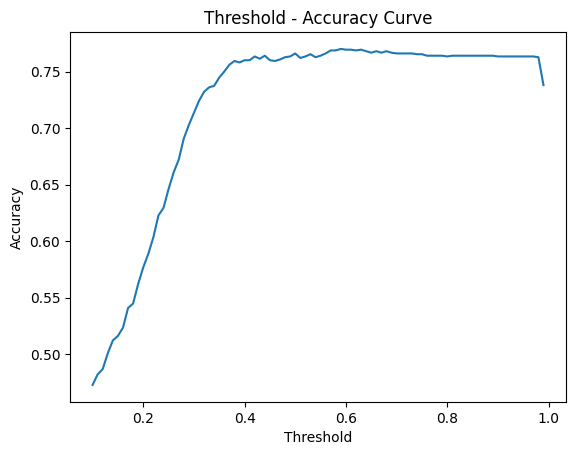

In [30]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt


# 假设你已经有训练集和测试集数据 X_train, X_test, y_train, y_test
# 这里省略数据加载和划分的代码

# 定义 LightGBM 模型，使用已知的最佳参数
lgb_model = lgb.LGBMClassifier(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    num_leaves=31,
    subsample=0.8,
    random_state=42
)

# 训练模型
lgb_model.fit(X_train, y_train)

# 在测试集上进行预测
y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

# 输出测试集 AUC
print("测试集 AUC: ", roc_auc_score(y_test, y_pred_proba))

# 初始化列表用于存储不同阈值下的准确率
accuracies = []
thresholds = np.arange(0.1, 1, 0.01)

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# 找到最大准确率及其对应的阈值
max_accuracy_index = np.argmax(accuracies)
optimal_threshold = thresholds[max_accuracy_index]
max_accuracy = accuracies[max_accuracy_index]

print(f"最佳阈值: {optimal_threshold}")
print(f"最大准确率: {max_accuracy}")

# 绘制阈值 - 准确率曲线
plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Threshold - Accuracy Curve')
plt.show()

# 结果可视化


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1338, number of negative: 3462
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1856
[LightGBM] [Info] Number of data points in the train set: 4800, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.278750 -> initscore=-0.950670
[LightGBM] [Info] Start training from score -0.950670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

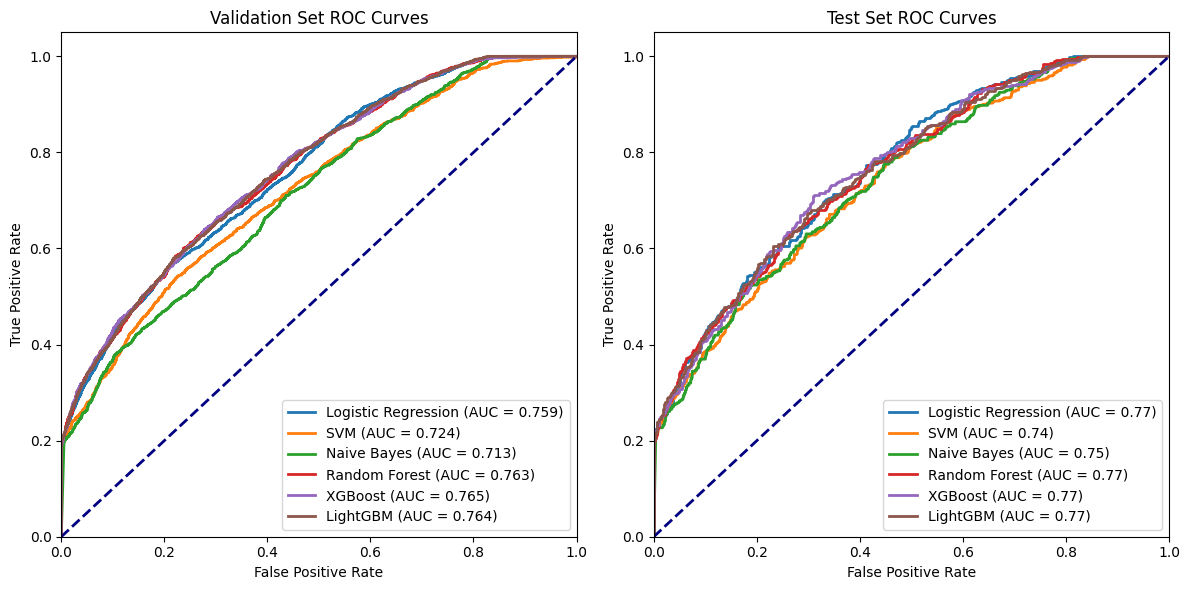

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# 假设你已经有了数据集 X_train, X_test, y_train, y_test

# 定义模型及其最佳参数
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(C=10, gamma='auto', kernel='rbf', probability=True),
    "Naive Bayes": GaussianNB(var_smoothing=1e-5),
    "Random Forest": RandomForestClassifier(
        max_depth=10, max_features='sqrt', min_samples_leaf=1,
        min_samples_split=10, n_estimators=200
    ),
    "XGBoost": xgb.XGBClassifier(
        colsample_bytree=0.8, learning_rate=0.1, max_depth=3,
        n_estimators=100, subsample=0.8
    ),
    "LightGBM": lgb.LGBMClassifier(
        colsample_bytree=0.8, learning_rate=0.1, max_depth=5,
        n_estimators=100, num_leaves=31, subsample=0.8
    )
}

# 绘制验证集的 ROC 曲线
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 左边图：验证集

for name, model in models.items():
    # 使用交叉验证获取验证集的预测概率
    y_pred_val = cross_val_predict(model, X_train, y_train, cv=5, method='predict_proba')[:, 1]
    fpr, tpr, _ = roc_curve(y_train, y_pred_val)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Set ROC Curves')
plt.legend(loc="lower right")

# 绘制测试集的 ROC 曲线
plt.subplot(1, 2, 2)  # 右边图：测试集

for name, model in models.items():
    # 训练模型并在测试集上进行预测
    model.fit(X_train, y_train)
    y_pred_test = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_test)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Curves')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# 逻辑回归解释

         Current function value: 0.457313
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:         Credit Default   No. Observations:                 6000
Model:                          Logit   Df Residuals:                     5969
Method:                           MLE   Df Model:                           30
Date:                Tue, 04 Mar 2025   Pseudo R-squ.:                  0.2271
Time:                        00:13:13   Log-Likelihood:                -2743.9
converged:                      False   LL-Null:                       -3550.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -0.0134        nan        nan        nan         nan         nan
Annual Inco

c:\Users\windmoon07\anaconda3\envs\py38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


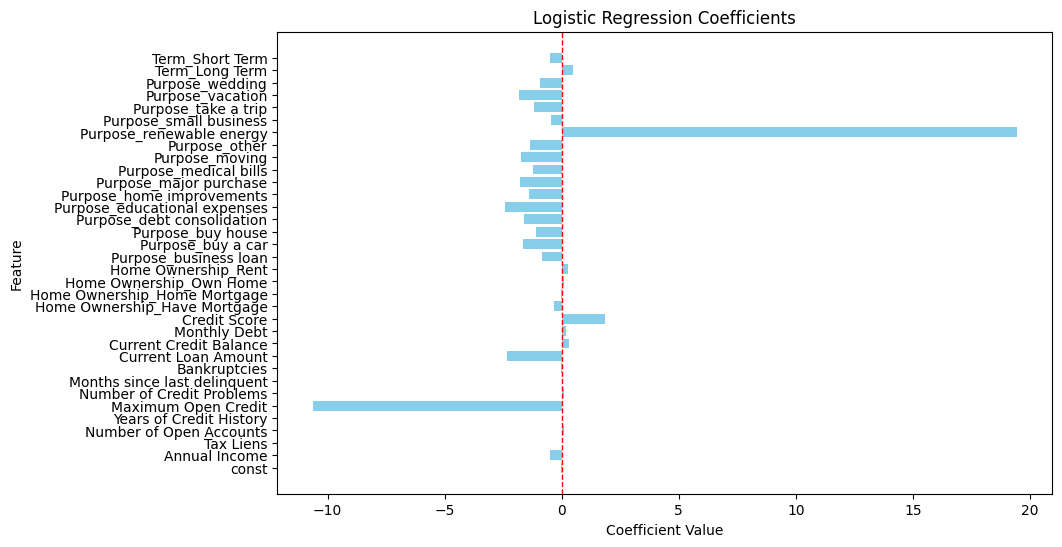

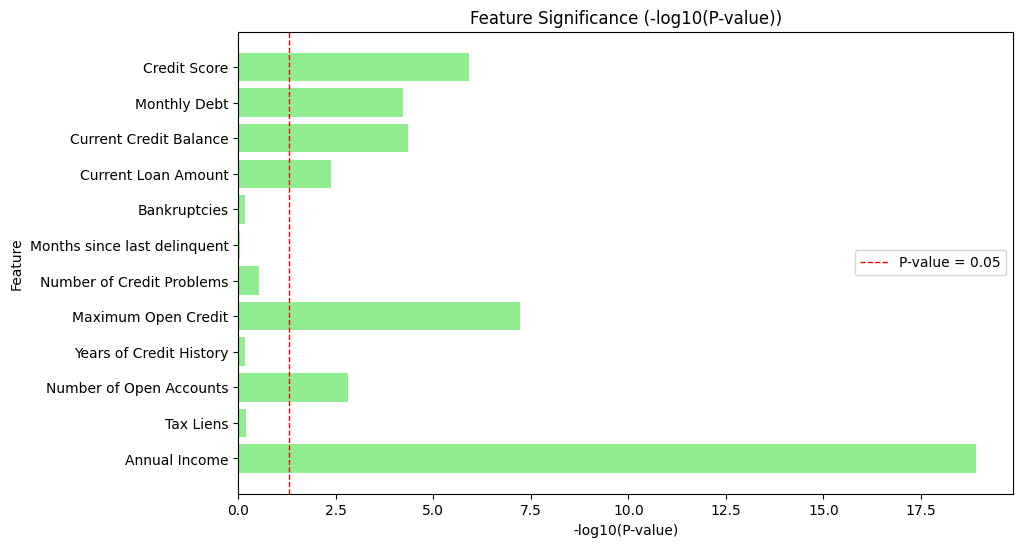

In [33]:

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 假设你已经有了数据集 X_train, y_train

# 添加常数项（截距）
X_train_const = sm.add_constant(X_train)

# 使用 statsmodels 拟合逻辑回归模型
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# 输出模型摘要
print(result.summary())

# 提取系数和 p 值
params = result.params  # 系数
p_values = result.pvalues  # p 值

# 创建一个 DataFrame 来存储系数和 p 值
coef_df = pd.DataFrame({
    'Feature': X_train_const.columns,
    'Coefficient': params,
    'P-value': p_values
})

# 打印系数和 p 值
print(coef_df)

# 绘制显著性图（系数条形图）
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.show()

# 绘制显著性图（p 值条形图）
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], -np.log10(coef_df['P-value']), color='lightgreen')
plt.axvline(x=-np.log10(0.05), color='red', linestyle='--', linewidth=1, label='P-value = 0.05')
plt.xlabel('-log10(P-value)')
plt.ylabel('Feature')
plt.title('Feature Significance (-log10(P-value))')
plt.legend()
plt.show()

# 逻辑回归结果

## 模型概览
- **因变量**: Credit Default
- **样本数**: 6000
- **伪 R 方 (Pseudo R-squ.)**: 0.2271
- **对数似然值 (Log-Likelihood)**: -2743.9
- **LL-Null**: -3550.1
- **LLR p-value**: 0.000

## 显著特征（p-value < 0.05）

| 特征名称                  | 系数 (Coefficient) | 标准误差 (Std Error) | P 值 (P-value) | 置信区间 (95%)         |
|---------------------------|--------------------|----------------------|----------------|------------------------|
| Annual Income             | -0.5053            | 0.056                | 0.000          | [-0.615, -0.396]       |
| Number of Open Accounts   | 0.1201             | 0.038                | 0.002          | [0.046, 0.194]         |
| Maximum Open Credit       | -10.6414           | 1.963                | 0.000          | [-14.490, -6.793]      |
| Current Loan Amount       | -2.3343            | 0.813                | 0.004          | [-3.928, -0.740]       |
| Current Credit Balance    | 0.2998             | 0.074                | 0.000          | [0.156, 0.444]         |
| Monthly Debt              | 0.1913             | 0.048                | 0.000          | [0.098, 0.285]         |
| Credit Score              | 1.8592             | 0.383                | 0.000          | [1.109, 2.610]         |

## 不显著特征（p-value ≥ 0.05）

| 特征名称                  | 系数 (Coefficient) | 标准误差 (Std Error) | P 值 (P-value) | 置信区间 (95%)         |
|---------------------------|--------------------|----------------------|----------------|------------------------|
| Tax Liens                 | 0.0257             | 0.054                | 0.634          | [-0.080, 0.132]        |
| Years of Credit History   | 0.0144             | 0.036                | 0.688          | [-0.056, 0.085]        |
| Number of Credit Problems | 0.0834             | 0.080                | 0.298          | [-0.074, 0.240]        |
| Months since last delinquent | -0.0038        | 0.033                | 0.908          | [-0.069, 0.061]        |
| Bankruptcies              | -0.0269            | 0.064                | 0.676          | [-0.153, 0.099]        |
| Home Ownership_Have Mortgage | -0.3472       | 2.77e+06             | 1.000          | [-5.43e+06, 5.43e+06]  |
| Home Ownership_Home Mortgage | -0.0479       | 2.69e+06             | 1.000          | [-5.27e+06, 5.27e+06]  |
| Home Ownership_Own Home   | 0.1088             | 2.71e+06             | 1.000          | [-5.31e+06, 5.31e+06]  |
| Home Ownership_Rent       | 0.2730             | 2.83e+06             | 1.000          | [-5.55e+06, 5.55e+06]  |
| Purpose_business loan     | -0.8357            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_buy a car         | -1.6371            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_buy house         | -1.0777            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_debt consolidation | -1.6034           | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_educational expenses | -2.4262         | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_home improvements | -1.3765            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_major purchase    | -1.7681            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_medical bills     | -1.2326            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_moving            | -1.7331            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_other             | -1.3692            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_renewable energy  | 19.4472            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_small business    | -0.4564            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_take a trip       | -1.1906            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_vacation          | -1.8112            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Purpose_wedding           | -0.9428            | 3.64e+06             | 1.000          | [-7.14e+06, 7.14e+06]  |
| Term_Long Term            | 0.4766             | 3.19e+06             | 1.000          | [-6.24e+06, 6.24e+06]  |
| Term_Short Term           | -0.4900            | 3.19e+06             | 1.000          | [-6.24e+06, 6.24e+06]  |

# 机器学习可解释性分析

原则上挑选表现最好的模型，对其利用shap和pdpbox库进行可解释性分析

这里我们选取lightgbm模型进行可解释性分析，虽然他不是表现最好的，但是他计算速度最快，你可以说自己其实是对随机森林解释的，没有什么区别

In [34]:
# shap解释需要计算shap值，才可以后续可视化
import shap
import lightgbm as lgb

# 使用最佳参数重新训练一个新的 LightGBM 模型
best_params = {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 63}
lgb_best = lgb.LGBMClassifier(**best_params)
lgb_best.fit(X_train, y_train)

# 使用 shap 进行解释
# 创建一个 SHAP 解释器，使用训练好的 LightGBM 模型
explainer = shap.Explainer(lgb_best)

# 计算 SHAP 值，使用训练集
shap_values = explainer.shap_values(X_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1672, number of negative: 4328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1872
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.278667 -> initscore=-0.951085
[LightGBM] [Info] Start training from score -0.951085


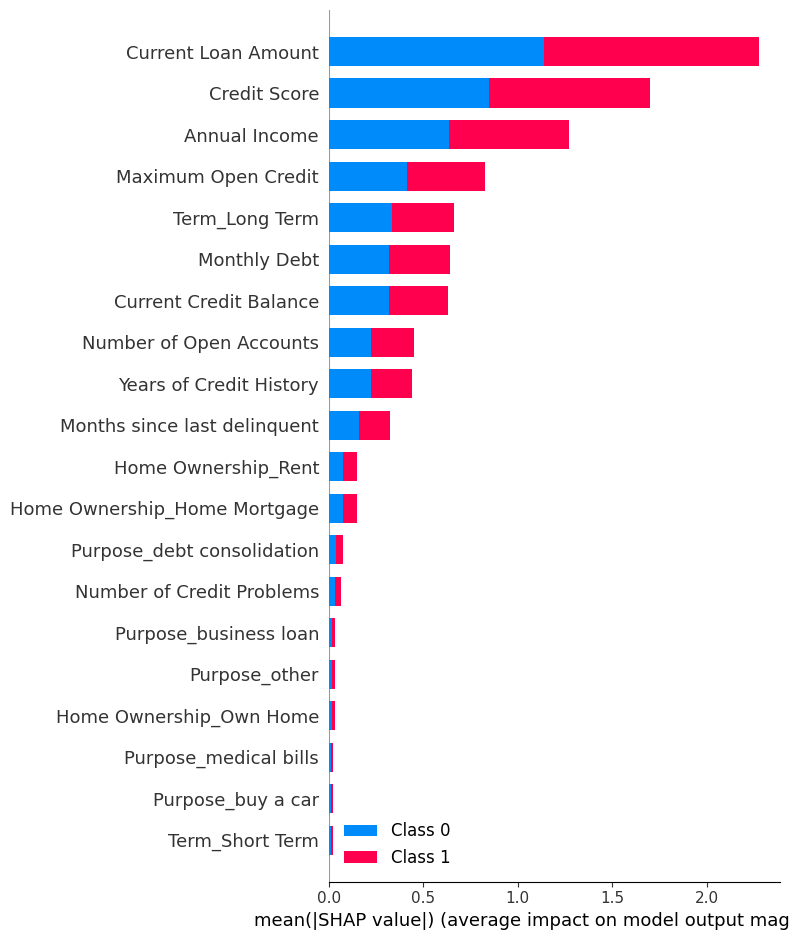

In [35]:
# 可视化所有类别的SHAP 汇总图
shap.summary_plot(shap_values, X_train)

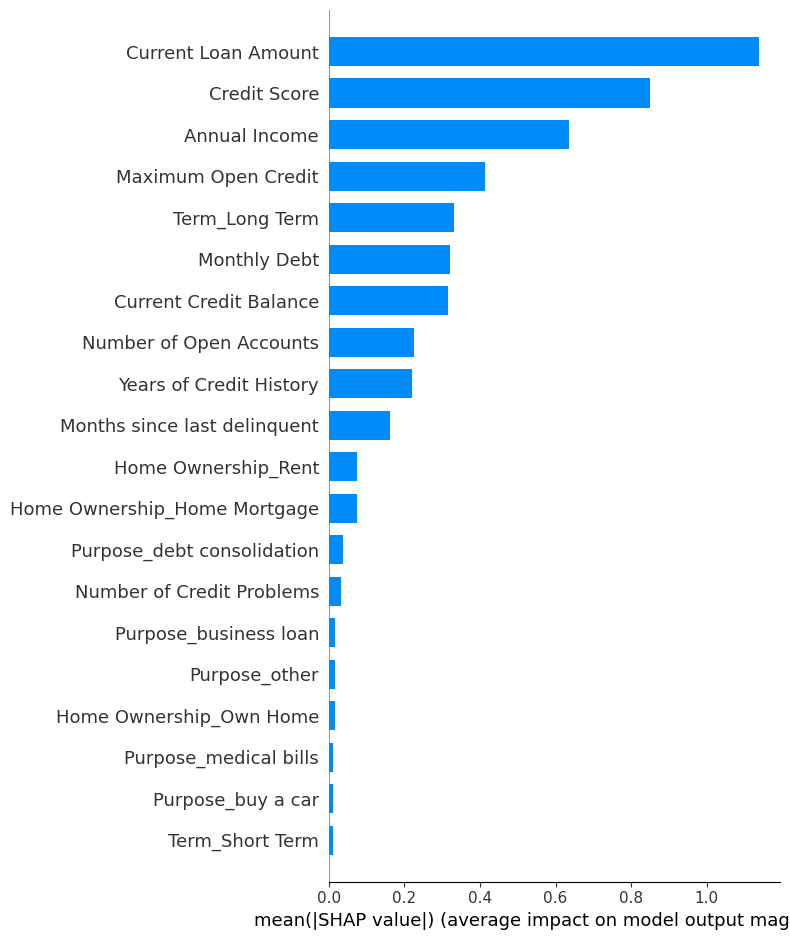

In [36]:
# SHAP 汇总图设置为条形图，可以显示特征重要性
shap.summary_plot(shap_values[1], X_train, plot_type="bar")

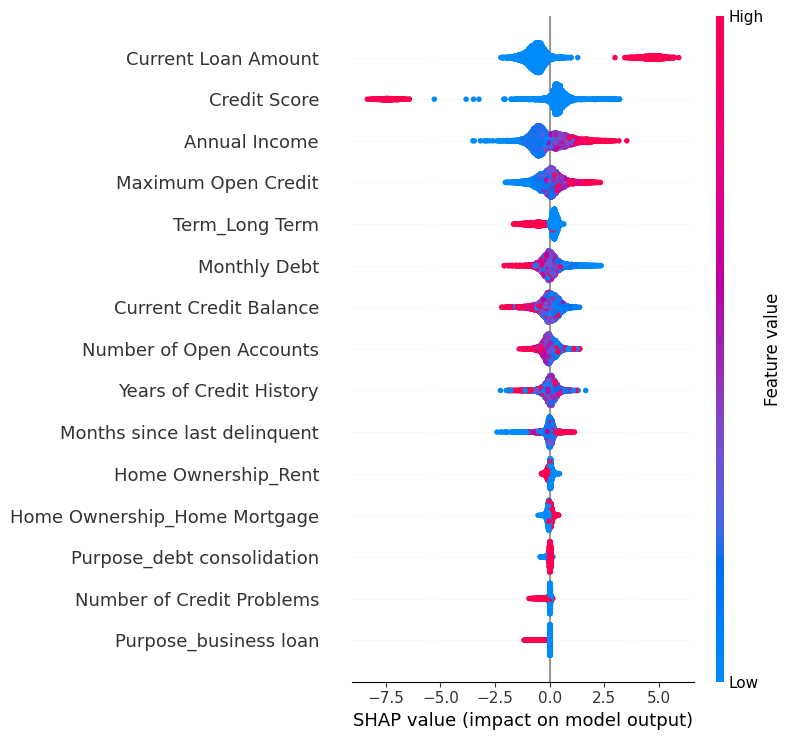

In [37]:
# SHAP 汇总图默认设置为点图，可以反应特征的重要性和影响方向
shap.summary_plot(shap_values[0], X_train,plot_type="dot", max_display=15)

In [38]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 970 to 2669
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 1500 non-null   float64
 1   Tax Liens                     1500 non-null   float64
 2   Number of Open Accounts       1500 non-null   float64
 3   Years of Credit History       1500 non-null   float64
 4   Maximum Open Credit           1500 non-null   float64
 5   Number of Credit Problems     1500 non-null   float64
 6   Months since last delinquent  1500 non-null   float64
 7   Bankruptcies                  1500 non-null   float64
 8   Current Loan Amount           1500 non-null   float64
 9   Current Credit Balance        1500 non-null   float64
 10  Monthly Debt                  1500 non-null   float64
 11  Credit Score                  1500 non-null   float64
 12  Home Ownership_Have Mortgage  1500 non-null   float64
 13  Home O

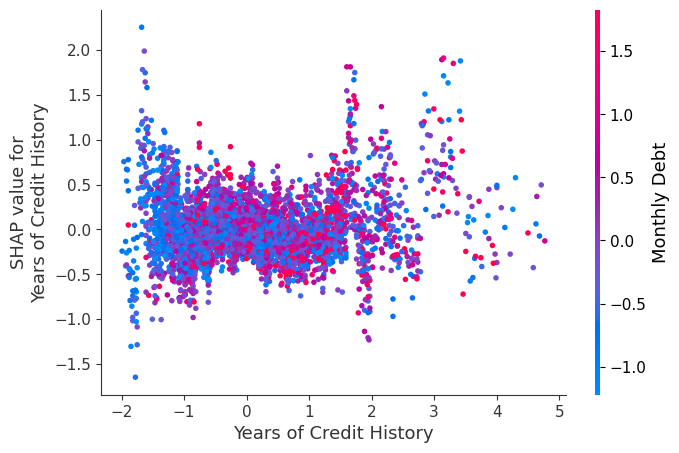

In [39]:
# 同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('Years of Credit History', shap_values[1], X_train, interaction_index="Monthly Debt")
# shap.dependence_plot('Tax Liens', shap_values[1], X_train, interaction_index="Annual Income")

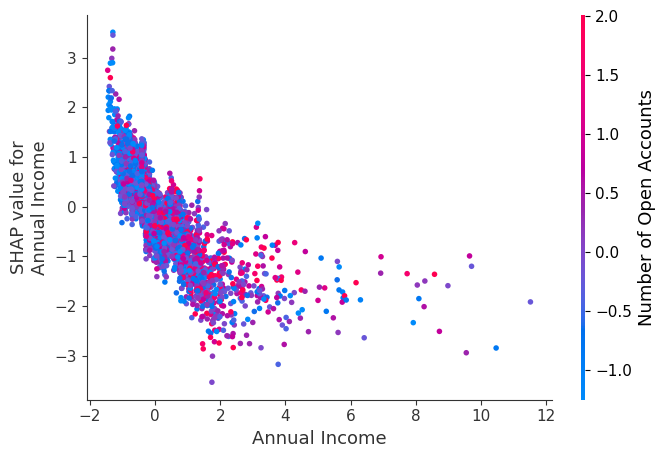

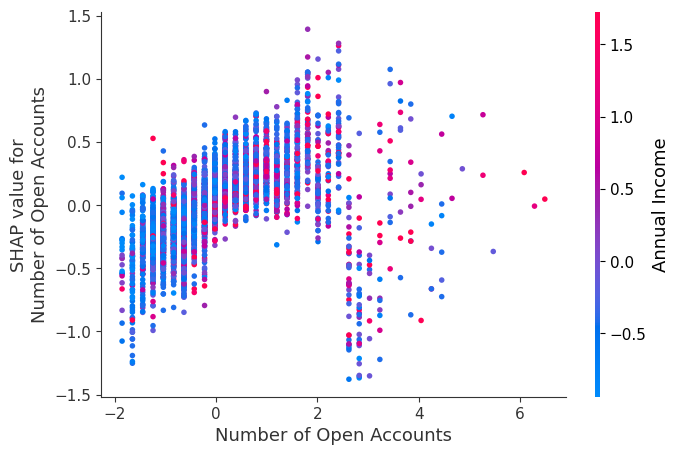

In [40]:
# 同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('Annual Income', shap_values[1], X_train, interaction_index="Number of Open Accounts")
shap.dependence_plot('Number of Open Accounts', shap_values[1], X_train, interaction_index="Annual Income")

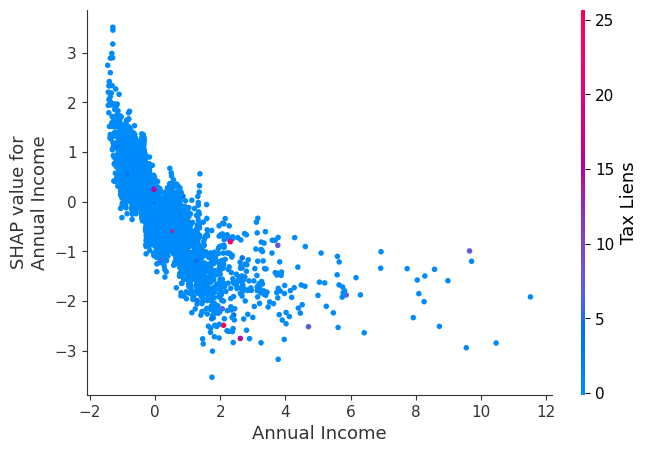

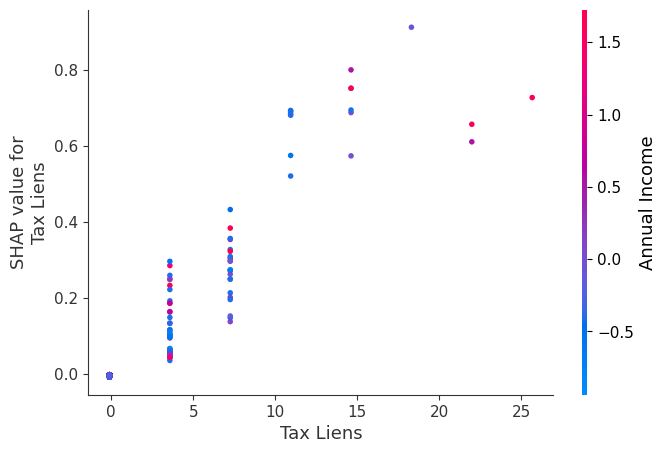

In [41]:
# 同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('Annual Income', shap_values[1], X_train, interaction_index="Tax Liens")
shap.dependence_plot('Tax Liens', shap_values[1], X_train, interaction_index="Annual Income")

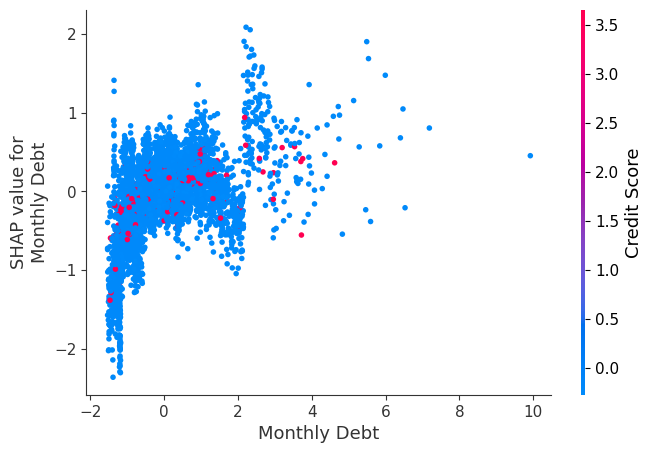

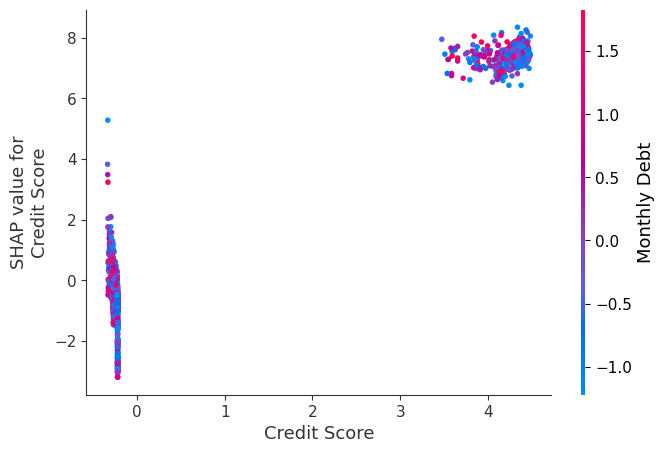

In [42]:
# 同样的交互效应，也要在意数据的分布来优化可视化的图形
shap.dependence_plot('Monthly Debt', shap_values[1], X_train, interaction_index="Credit Score")
shap.dependence_plot('Credit Score', shap_values[1], X_train, interaction_index="Monthly Debt")

In [43]:
# 绘制交互效应热力图，这个要计算很久
shap_interaction_values = explainer.shap_interaction_values(X_train)

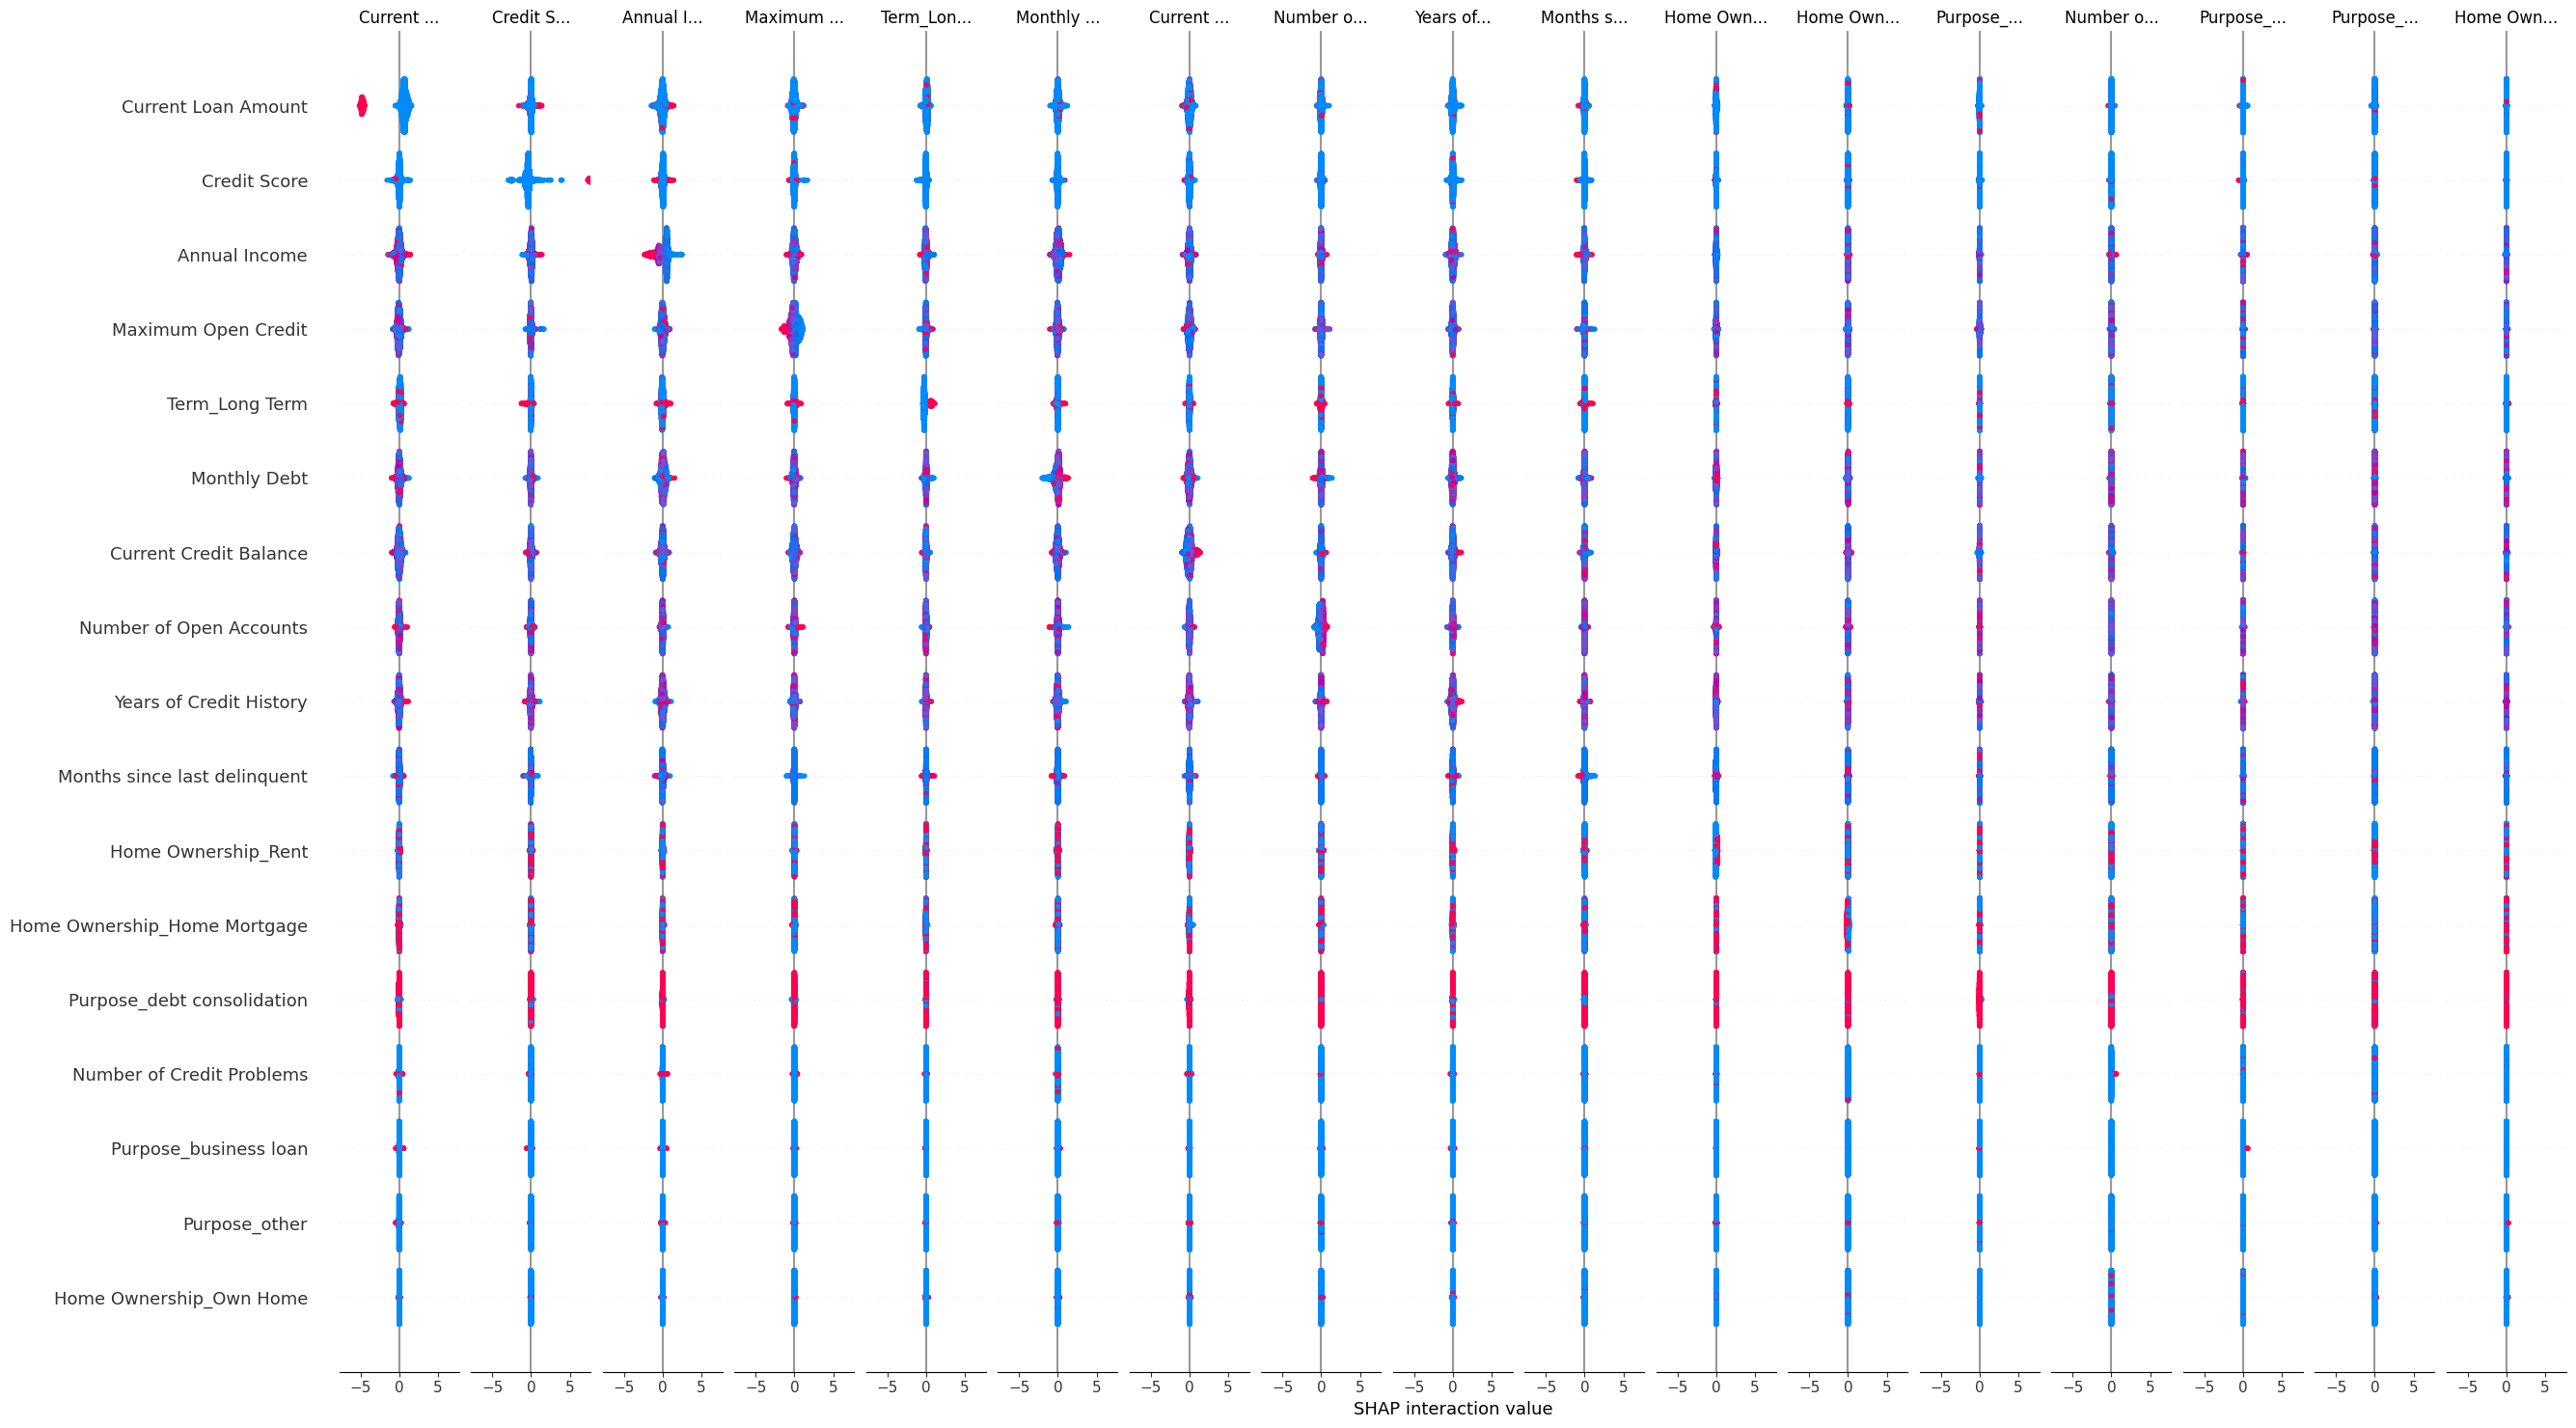

In [44]:
# shap的交互是比较复杂的协同关系，并不是简单的相乘
# 可视化交互效应，max_display这个参数可以控制显示的特征数量，这个特征的顺序是重要度顺序
shap.summary_plot(shap_interaction_values, X_train, max_display=17)

# 如果分布在0附近，说明这个特征交互对模型的影响不大
# 如果分布在两端，说明这个特征交互对模型的影响很大
# 这个要运行很久